In [231]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow.models.rnn import rnn    
from tensorflow.models.rnn.rnn_cell import BasicLSTMCell, LSTMCell
from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np
import collections
import cPickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import mpld3
from datetime import datetime, timedelta, date
import time
import socket
import struct

In [2]:
%matplotlib inline

# Enable mpld3 for notebook
mpld3.enable_notebook()

# Timestamp goodness
def timestamp(dataframe):
    timestamps = []
    for row in dataframe.iterrows():
        timestamps.append(time.ctime(row[1][4] - (row[1][3] - row[1][19]) / 1000))
    dataframe['TIMESTAMP'] = timestamps
    return dataframe

In [3]:
np.random.seed(1234)

In [4]:
# Import netflow capture file(s)

# Crate dataframe
brocade_flowdata = pd.DataFrame()

# List of csv's to read in
brocade_cap_files = ["/home/ehenry/code/ml/classifier_examples/1454084206.csv"]

# Read in the csv's and append to dataframe
for f in brocade_cap_files:
    frame = pd.read_csv(f, sep=';')
    brocade_flowdata = brocade_flowdata.append(frame, ignore_index=True)

In [5]:
# Convert and append timestamps
#brocade_flowdata_ts = timestamp(brocade_flowdata)

In [6]:
# Convert variables to respective type
# cont = continuous
# cat = categorical

cat_cols = ['nfHost','nfSourceID','sequenceNumber','flowSetID','PROTOCOL',
            'TOS', 'TCP_FLAGS','L4_SRC_PORT','IPV4_SRC_ADDR','INPUT_SNMP',
            'L4_DST_PORT','IPV4_DST_ADDR','OUTPUT_SNMP','IPV6_SRC_ADDR',
            'IPV6_DST_ADDR','ICMP_TYPE',
            'DIRECTION','flowId','postNATSourceIPv4Address',
            'postNATDestinationIPv4Address','postNAPTSourceTransportAddress',
            'postNAPTDestinationTransportAddress','firewallEvent',
            'postNATSourceIPv6Address','postNATDestinationIPv6Address',
            'privateEnterpriseNumber','App-ID','User-ID']

cont_cols = ['timeReceived','IN_BYTES',
             'sysUpTime','unixSeconds','FIRST_SWITCHED',
             'LAST_SWITCHED']

for c in cat_cols:
    brocade_flowdata[c] = brocade_flowdata[c].astype('category')

for c in cont_cols:
    brocade_flowdata[c] = brocade_flowdata[c].astype('float64')

# Strip whitespace
brocade_flowdata.rename(columns=lambda x: x.strip(), inplace = True)

In [7]:
ipv4_brcd_flwdt = brocade_flowdata.loc[:,['PROTOCOL','IPV4_SRC_ADDR',
                                          'IPV4_DST_ADDR','L4_DST_PORT']]

ipv4_brcd_flwdt = ipv4_brcd_flwdt.dropna()

cats_10 = ['PROTOCOL','IPV4_SRC_ADDR',
           'IPV4_DST_ADDR','L4_DST_PORT',]

for c in cats_10:
    ipv4_brcd_flwdt[c] = ipv4_brcd_flwdt[c].astype('string')

In [8]:
ipv4_brcd_flwdt.head(n=5)

PROTOCOL  IPV4_SRC_ADDR   IPV4_DST_ADDR L4_DST_PORT
0        6  10.252.132.20   216.58.192.46         443
1        6   10.252.132.6    192.168.1.23       52323
2       17    10.70.20.23  61.172.201.254          53
3        6    10.130.53.5     23.5.251.27          80
4       17  10.252.131.68     10.70.20.23          53

In [137]:
def read_flows(dataframe, fmt='list'):
    l = []
    for row in dataframe.iterrows():
        flow = []
        for f in row[1]:
            flow.append(f)
        if fmt == 'string':
            str1 = ''.join(str(e) for e in flow)
            l.append(str1)
        if fmt == 'list':
            l.append(flow)
    return l

def preprocess(dataframe, fmt):
    counter = collections.Counter(read_flows(dataframe, fmt))
    count_pairs = sorted(counter.items(), key=lambda x: -x[1])
    chars, _ = list(zip(*count_pairs))
    vocab_size = len(chars)
    vocab = dict(zip(chars, range(len(chars))))
    tensor = np.array(map(vocab.get, read_flows(dataframe, fmt)))
    with open("vocab.pkl", 'w') as f:
        cPickle.dump(chars, f)
    np.save("data.npy", tensor)
    return list(chars)

def bin_process(dataframe):
    flows = read_flows(dataframe, fmt='list')
    binary_reps = []
    for flow in flows:
        bin_rep = []
        bin_rep.append("{0:b}".format(int(flow[0])))
        assert flow[1].count(".") == 3
        ip_parts = flow[1].split(".")
        ip_parts = ["{0:b}".format(int(part)) for part in ip_parts]
        bin_rep.extend(ip_parts)
        assert flow[2].count(".") == 3
        ip_parts_1 = flow[2].split(".")
        ip_parts_1 = ["{0:b}".format(int(part)) for part in ip_parts_1]
        bin_rep.extend(ip_parts_1)
        bin_rep.append("{0:b}".format(int(flow[3])))
        binary_reps.append(bin_rep)
    return binary_reps

def octet_process(dataframe):
    flows = read_flows(dataframe, fmt='list')
    binary_reps = []
    for flow in flows:
        bin_rep = []
        bin_rep.append(int(flow[0]))
        assert flow[1].count(".") == 3
        ip_parts = flow[1].split(".")
        ip_parts = [int(part) for part in ip_parts]
        bin_rep.extend(ip_parts)
        assert flow[2].count(".") == 3
        ip_parts_1 = flow[2].split(".")
        ip_parts_1 = [int(part) for part in ip_parts_1]
        bin_rep.extend(ip_parts_1)
        bin_rep.append(int(flow[3]))
        binary_reps.append(bin_rep)
    return binary_reps

In [10]:
test = preprocess(ipv4_brcd_flwdt[15261:18800], fmt='string')
test[0:5]

['610.70.80.120216.58.192.46443',
 '1710.252.132.4110.70.20.2353',
 '1710.252.132.6710.70.20.2353',
 '610.70.80.12023.203.212.218443',
 '1710.252.132.310.70.20.4353']

### Testing using stringified representation of flows decomposed into each character in the flow data capture. Each character is then converted to ASCII and embedded in gray space

In [11]:
#del ascii_codes
ascii_codes = []
for i in test:
    for c in i:
        ascii_codes.append(ord(c))
        
ascii_array = np.asarray(ascii_codes)
len(ascii_array)

67802

In [134]:
#del reshape_array
reshape_array = np.reshape(ascii_array[0:65536], (-1, np.sqrt(len(ascii_array[0:65536]))))
reshape_array

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:225: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


array([[54, 49, 48, ..., 55, 56, 48],
       [49, 55, 49, ..., 56, 48, 54],
       [49, 48, 46, ..., 51, 52, 55],
       ..., 
       [46, 49, 50, ..., 50, 49, 49],
       [49, 50, 56, ..., 48, 53, 52],
       [46, 50, 51, ..., 49, 48, 46]])

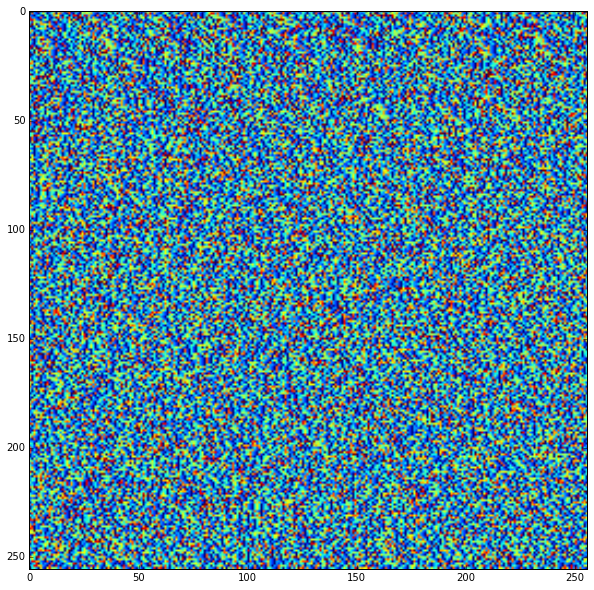

In [135]:
plt.figure(figsize=(10,10))
plt.imshow(reshape_array,aspect='auto')
plt.savefig('testing.jpg')
plt.show()

### Decomposing each flow entry into its binary representation and then embedded in b/w space

In [126]:
testing = bin_process(ipv4_brcd_flwdt[25000:30000])
long_array = []
for array in testing:
    for bits in array:
        for bit in bits:
            long_array.append(int(bit))

len(long_array)

316000

In [127]:
reshape_long_array = np.reshape(long_array[16384:32768], (-1, np.sqrt(len(long_array[16384:32768]))))
np.shape(reshape_long_array)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:48: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result = getattr(asarray(obj), method)(*args, **kwds)


(128, 128)

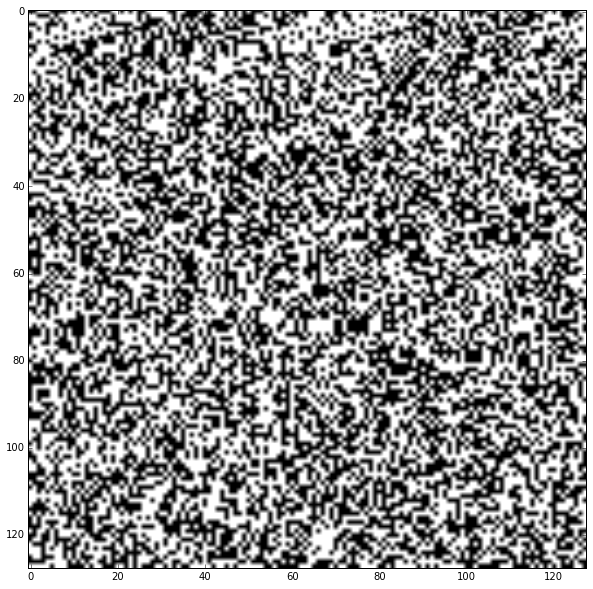

In [131]:
plt.figure(figsize=(10,10))
plt.imshow(reshape_long_array, cmap='gray', aspect='auto')
plt.show()

### Now trying to embed each octect of each flow directly into RGB space

In [143]:
octet_testing = octet_process(ipv4_brcd_flwdt[0:10000])
len(octet_testing)

10000

In [144]:
octet_vector = []
for flow in octet_testing:
    for octet in flow:
        octet_vector.append(octet)

octet_array = np.asarray(octet_vector)

In [160]:
reshape_octet_array = np.reshape(octet_array[0:4096], (-1, np.sqrt(len(octet_array[0:4096]))))
np.shape(reshape_octet_array)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:225: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


(64, 64)

In [206]:
#print(octet_array[0:500])
print(reshape_octet_array[0:2])

[[    6    10   252   132    20   216    58   192    46   443     6    10
    252   132     6   192   168     1    23 52323    17    10    70    20
     23    61   172   201   254    53     6    10   130    53     5    23
      5   251    27    80    17    10   252   131    68    10    70    20
     23    53    17    10    70    20    43   205   251   195   166    53
      6   192   168     1]
 [   23    10   252   132     6 59043    17    10    70    20    23    10
    252   131    68 55105     6    10   102   137   218    54   246   126
    156    80     6    10   252   132     7    10    70    20   124   389
      6    10    70    20   124    10   252   132     7 64835     6    10
    252   131    52   172    16    12    79  4713    17    10   252   132
     20   216    58   192]]


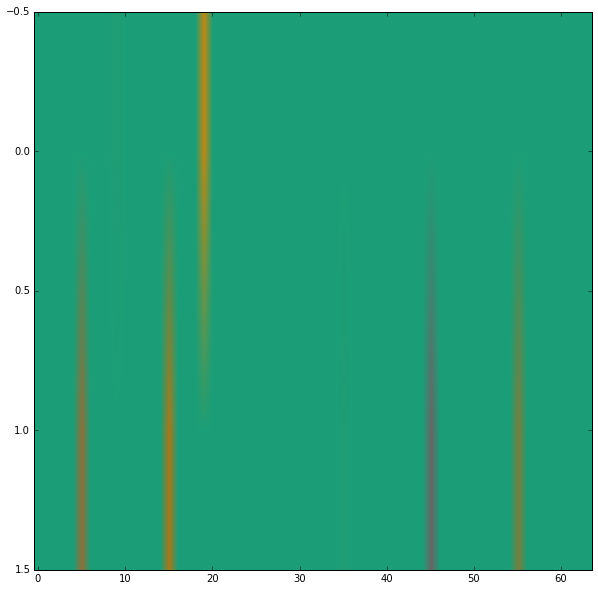

In [210]:
plt.figure(figsize=(10,10))
plt.imshow(reshape_octet_array[0:2], aspect='auto', cmap='Dark2')
plt.show()

In [234]:
image_test = [6, 10, 252, 132, 20, 216, 58, 192, 46, 443, 6, 10,
              252, 132, 6, 192, 168, 1, 23, 52323, 17, 10, 70, 20,
              23, 61, 172, 201, 254, 53, 6, 10, 130, 53, 5, 23,
              5, 251, 27, 80, 17, 10, 252, 131, 68, 10, 70, 20,
              23, 53, 17, 10, 70, 20, 43, 205, 251, 195, 166, 53,
              6, 192, 168, 1]

image_array = np.asarray(image_test)
print(np.shape(image_array))
print(image_array)

norm1 = image_test / np.linalg.norm(image_test)
norm2 = normalize(image_test[:,np.newaxis]).ravel()
print(np.all(norm1==norm2))

(64,)
[    6    10   252   132    20   216    58   192    46   443     6    10
   252   132     6   192   168     1    23 52323    17    10    70    20
    23    61   172   201   254    53     6    10   130    53     5    23
     5   251    27    80    17    10   252   131    68    10    70    20
    23    53    17    10    70    20    43   205   251   195   166    53
     6   192   168     1]


TypeError: list indices must be integers, not tuple

In [229]:
reshape_image_test = np.reshape(image_test, (-1, np.sqrt(len(image_test))))
print(np.shape(reshape_image_test))
print(reshape_image_test)

(8, 8)
[[    6    10   252   132    20   216    58   192]
 [   46   443     6    10   252   132     6   192]
 [  168     1    23 52323    17    10    70    20]
 [   23    61   172   201   254    53     6    10]
 [  130    53     5    23     5   251    27    80]
 [   17    10   252   131    68    10    70    20]
 [   23    53    17    10    70    20    43   205]
 [  251   195   166    53     6   192   168     1]]


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:48: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result = getattr(asarray(obj), method)(*args, **kwds)


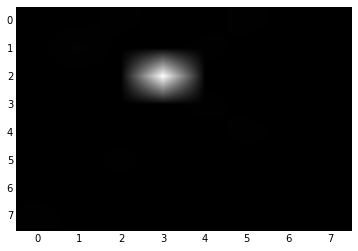

In [230]:
#plt.figure(figsize=(10,10))
plt.imshow(reshape_image_test, aspect='auto', cmap='gray')
plt.show()

In [99]:
# hacking an imlpementaiton of an lstm together
def __init__(self, is_training, config):
    batch_size = batch_size = config.batch_size
    num_steps = num_steps = config.num_steps
    size = config.hidden_size
    vocab_size = config.vocab_size

    _input_data = tf.placeholder(tf.int32, [batch_size, num_steps])
    _targets = tf.placeholder(tf.int32, [batch_size, num_steps])

    # Slightly better results can be obtained with forget gate biases
    # initialized to 1 but the hyperparameters of the model would need to be
    # different than reported in the paper.
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(size, forget_bias=0.0)
    
    if is_training and config.keep_prob < 1:
        lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=config.keep_prob)
        
    cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * config.num_layers)
    
    ## Initialize the states of the cells
    _initial_state = cell.zero_state(batch_size, tf.float32)

    with tf.device("/cpu:0"):
        embedding = tf.get_variable("embedding", [vocab_size, size])
        inputs = tf.nn.embedding_lookup(embedding, _input_data)

    if is_training and config.keep_prob < 1:
        inputs = tf.nn.dropout(inputs, config.keep_prob)

    # Simplified version of tensorflow.models.rnn.rnn.py's rnn().
    # This builds an unrolled LSTM for tutorial purposes only.
    # In general, use the rnn() or state_saving_rnn() from rnn.py.
    #
    # The alternative version of the code below is:
    #
    # from tensorflow.models.rnn import rnn
    # inputs = [tf.squeeze(input_, [1])
    #           for input_ in tf.split(1, num_steps, inputs)]
    # outputs, state = rnn.rnn(cell, inputs, initial_state=_initial_state)
    outputs = []
    state = _initial_state
    with tf.variable_scope("RNN"):
        for time_step in range(num_steps):
            if time_step > 0: tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(inputs[:, time_step, :], state)
            outputs.append(cell_output)

    output = tf.reshape(tf.concat(1, outputs), [-1, size])
    softmax_w = tf.get_variable("softmax_w", [size, vocab_size])
    softmax_b = tf.get_variable("softmax_b", [vocab_size])
    logits = tf.matmul(output, softmax_w) + softmax_b
    loss = tf.nn.seq2seq.sequence_loss_by_example(
        [logits],
        [tf.reshape(_targets, [-1])],
        [tf.ones([batch_size * num_steps])])
    _cost = cost = tf.reduce_sum(loss) / batch_size
    _final_state = state

    if not is_training:
        return

    _lr = tf.Variable(0.0, trainable=False)
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars),
                                      config.max_grad_norm)
    optimizer = tf.train.GradientDescentOptimizer(lr)
    _train_op = optimizer.apply_gradients(zip(grads, tvars))

def assign_lr(self, session, lr_value):
    session.run(tf.assign(lr, lr_value))

@property
def input_data(self):
    return _input_data

@property
def targets(self):
    return _targets

@property
def initial_state(self):
    return _initial_state

@property
def cost(self):
    return _cost

@property
def final_state(self):
    return _final_state

@property
def lr(self):
    return _lr

@property
def train_op(self):
    return _train_op


class SmallConfig(object):
    """Small config."""
    init_scale = 0.1
    learning_rate = 1.0
    max_grad_norm = 5
    num_layers = 2
    num_steps = 20
    hidden_size = 200
    max_epoch = 4
    max_max_epoch = 13
    keep_prob = 1.0
    lr_decay = 0.5
    batch_size = 20
    vocab_size = 10000


class MediumConfig(object):
    """Medium config."""
    init_scale = 0.05
    learning_rate = 1.0
    max_grad_norm = 5
    num_layers = 2
    num_steps = 35
    hidden_size = 650
    max_epoch = 6
    max_max_epoch = 39
    keep_prob = 0.5
    lr_decay = 0.8
    batch_size = 20
    vocab_size = 10000


class LargeConfig(object):
    """Large config."""
    init_scale = 0.04
    learning_rate = 1.0
    max_grad_norm = 10
    num_layers = 2
    num_steps = 35
    hidden_size = 1500
    max_epoch = 14
    max_max_epoch = 55
    keep_prob = 0.35
    lr_decay = 1 / 1.15
    batch_size = 20
    vocab_size = 10000


def run_epoch(session, m, data, eval_op, verbose=False):
    """Runs the model on the given data."""
    epoch_size = ((len(data) // m.batch_size) - 1) // m.num_steps
    start_time = time.time()
    costs = 0.0
    iters = 0
    state = m.initial_state.eval()
    for step, (x, y) in enumerate(reader.ptb_iterator(data, m.batch_size,
                                                    m.num_steps)):
        cost, state, _ = session.run([m.cost, m.final_state, eval_op],
                                     {m.input_data: x,
                                      m.targets: y,
                                      m.initial_state: state})
    costs += cost
    iters += m.num_steps

    if verbose and step % (epoch_size // 10) == 10:
        print("%.3f perplexity: %.3f speed: %.0f wps" %
              (step * 1.0 / epoch_size, np.exp(costs / iters),
               iters * m.batch_size / (time.time() - start_time)))

    return np.exp(costs / iters)


def get_config():
    if FLAGS.model == "small":
        return SmallConfig()
    elif FLAGS.model == "medium":
        return MediumConfig()
    elif FLAGS.model == "large":
        return LargeConfig()
    else:
        raise ValueError("Invalid model: %s", FLAGS.model)

def main(unused_args):

    raw_data = ipv4_brcd_flwdt.to_matrix()
    train_data, valid_data, test_data, _ = raw_data

    config = SmallConfig()
    eval_config = SmallConfig()
    eval_config.batch_size = 1
    eval_config.num_steps = 1

    with tf.Graph().as_default(), tf.Session() as session:
        initializer = tf.random_uniform_initializer(-config.init_scale,
                                                config.init_scale)
    with tf.variable_scope("model", reuse=None, initializer=initializer):
        m = PTBModel(is_training=True, config=config)
    with tf.variable_scope("model", reuse=True, initializer=initializer):
        mvalid = PTBModel(is_training=False, config=config)
        mtest = PTBModel(is_training=False, config=eval_config)

    tf.initialize_all_variables().run()

    for i in range(config.max_max_epoch):
        lr_decay = config.lr_decay ** max(i - config.max_epoch, 0.0)
        m.assign_lr(session, config.learning_rate * lr_decay)

        print("Epoch: %d Learning rate: %.3f" % (i + 1, session.run(m.lr)))
        train_perplexity = run_epoch(session, m, train_data, m.train_op,
                                   verbose=True)
        print("Epoch: %d Train Perplexity: %.3f" % (i + 1, train_perplexity))
        valid_perplexity = run_epoch(session, mvalid, valid_data, tf.no_op())
        print("Epoch: %d Valid Perplexity: %.3f" % (i + 1, valid_perplexity))

        test_perplexity = run_epoch(session, mtest, test_data, tf.no_op())

In [23]:
tf.app.run()

usage: __main__.py [-h]
__main__.py: error: unrecognized arguments: -f /home/ehenry/.ipython/profile_default/security/kernel-5ab38761-6ca0-4a93-b769-97865126e0d0.json --profile-dir /home/ehenry/.ipython/profile_default


SystemExit: 2

To exit: use 'exit', 'quit', or Ctrl-D.


TypeError: ord() expected string of length 1, but int found